# examining differences in the power spectrum based on filtering

Perhaps one reason we're getting strange results is due to applying a bandpass filter at 45 Hz. What if we don't apply a filter at all?

In [1]:
%matplotlib inline
import os
import glob
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from numpy import fft
from scipy import signal
from scipy import io
from sklearn import linear_model

srate = 512

Let's import three 20-second resting state datasets. They were applied the following bandpass filters, respectively:
- 0.5 - 45 Hz
- 0.5 - 150 Hz
- No filter

In [2]:
def import_subjects(import_path):
    subj = {}
    matfiles = []
    for root, dirs, files in os.walk(import_path):
        matfiles += glob.glob(os.path.join(root, '*.mat'))
    for i in range(len(matfiles)):
        datafile = sp.io.loadmat(matfiles[i])
        subj[i] = {}
        subj[i]['name'] = str(np.squeeze(datafile['name']))
        subj[i]['data'] = np.squeeze(datafile['data'])
    return subj

In [5]:
subj45  = import_subjects('../data/examine-slope-fit/45hz-filt')
subj150 = import_subjects('../data/examine-slope-fit/150hz-filt/')
subjnof = import_subjects('../data/examine-slope-fit/no-filt/')

In [6]:
def ransac_slope(f, psd, lofreq, hifreq):
    """
    Robustly fits line to the PSD, using the RANSAC algorithm. 
    Returns slope and fit line.
    """
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
    model_ransac.fit(f[lofreq*2:hifreq*2], np.log10(psd[lofreq*2:hifreq*2]))
    fit_line = model_ransac.predict(f)
    return model_ransac.estimator_.coef_[0][0] * (10**2), fit_line

def linreg_slope(f, psd, lofreq, hifreq):
    """
    Fits line to the PSD, using regular linear regression.
    Returns slope and fit line.
    """
    model = linear_model.LinearRegression()
    model.fit(f[2*2:24*2], np.log10(psd[2*2:24*2]))
    fit_line = model.predict(f)
    return model.coef_[0][0] * (10**2), fit_line

def process_subjects(subj):
    """
    Does the things.
    """
    for i in subj:
        for ch in range(len(subj[i]['data'])):
            subj[i][ch] = {}

            f, psd = sp.signal.welch(subj[i]['data'][ch], srate, nperseg=srate*2, noverlap=srate, window='hamming')
            f   = f.reshape((len(f), 1))
            psd = psd.reshape((len(psd), 1))
            
            subj[i][ch]['f'] = f
            subj[i][ch]['psd'] = psd
            
            # Remove alpha peak from the power spectrum:        
            subj[i][ch]['psd_rm_alpha'] = np.delete(psd, range(7*2, 14*2))
            subj[i][ch]['f_rm_alpha']   = np.delete(f, range(7*2, 14*2))
            subj[i][ch]['psd_rm_alpha'] = subj[i][ch]['psd_rm_alpha'].reshape((len(subj[i][ch]['psd_rm_alpha']), 1))
            subj[i][ch]['f_rm_alpha']   = subj[i][ch]['f_rm_alpha'].reshape((len(subj[i][ch]['f_rm_alpha']), 1))
            
            # Compute slope of this channel, and store fit line
            subj[i][ch]['ransac'], subj[i][ch]['fit_line_ransac'] = ransac_slope(subj[i][ch]['f_rm_alpha'], subj[i][ch]['psd_rm_alpha'], 2, 24)
            subj[i][ch]['linear'], subj[i][ch]['fit_line_linear'] = linreg_slope(subj[i][ch]['f_rm_alpha'], subj[i][ch]['psd_rm_alpha'], 2, 24)

        # Compute average slope for this subject
        subj[i]['avg_ransac'] = np.mean([subj[i][ch]['ransac'] for ch in range(len(subj[i]['data']))])
        subj[i]['avg_linear'] = np.mean([subj[i][ch]['linear'] for ch in range(len(subj[i]['data']))])
    return subj

In [7]:
subj45 = process_subjects(subj45)
subj150 = process_subjects(subj150)
subjnof = process_subjects(subjnof)

In [8]:
np.save('../data/examine-slope-fit/subj45.npy',  subj45)
np.save('../data/examine-slope-fit/subj150.npy', subj150)
np.save('../data/examine-slope-fit/subjnof.npy', subjnof)

In [9]:
len(subj45)

62

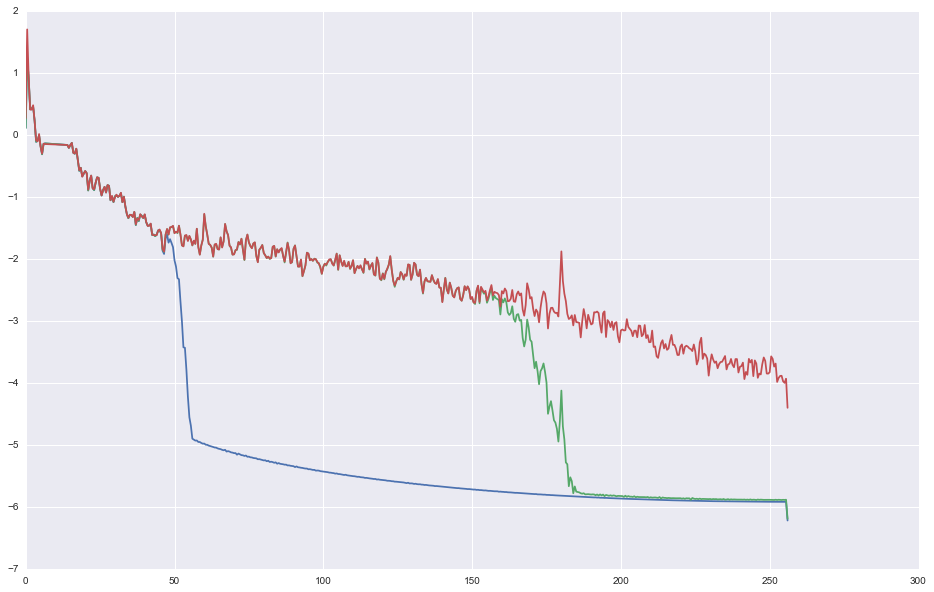

In [10]:
plt.figure(figsize=(16,10)); #plt.xlim([40, 55])
plt.plot(subj45[10][0]['f_rm_alpha'], np.log10(subj45[10][0]['psd_rm_alpha']))
plt.plot(subj150[10][0]['f_rm_alpha'], np.log10(subj150[10][0]['psd_rm_alpha']))
plt.plot(subjnof[10][0]['f_rm_alpha'], np.log10(subjnof[10][0]['psd_rm_alpha']))
# plt.plot(subjnof[5][0]['f_rm_alpha'], np.log10(subjnof[5][0]['psd_rm_alpha']))

(0, 100)

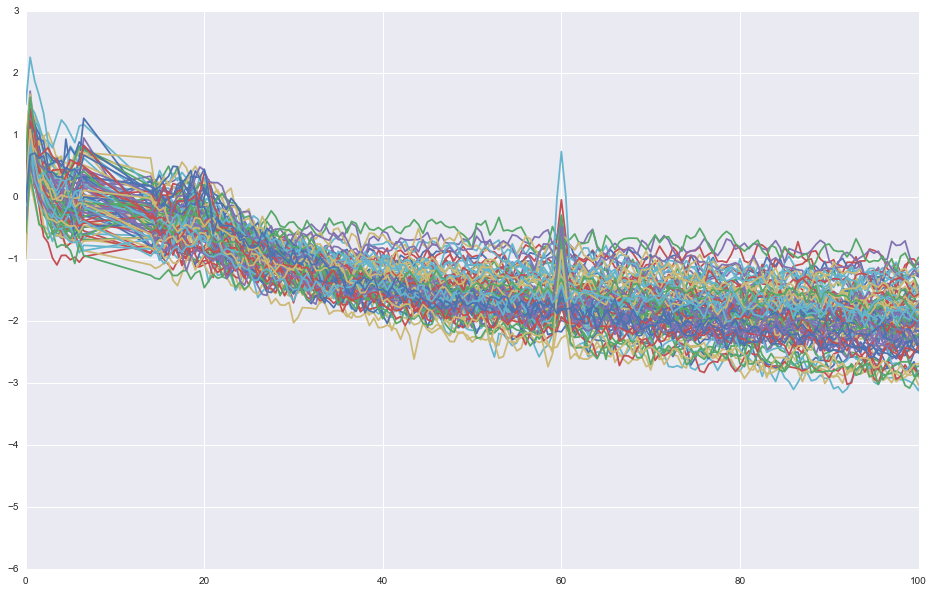

In [11]:
plt.figure(figsize=(16,10));
for i in range(len(subjnof)):
    plt.plot(subjnof[i][57]['f_rm_alpha'], np.log10(subjnof[i][57]['psd_rm_alpha']))
plt.xlim([0, 100])

Looks like the 20 - 45 or so range might provide the best place to fit fo slope. Going higher leads to pretty drastic flattening. 

In [11]:
subj45 = np.load('../data/examine-slope-fit/subj45.npy')
# subj150 = np.load('../data/examine-slope-fit/subj150.npy')
# subjnof = np.load('../data/examine-slope-fit/subjnof.npy')

In [5]:
voytek_slopes = []
experimental  = []
for i in range(len(subj150)):
    for ch in range(len(subj150[i]['data'])):
        voytek_slopes.append()
    voytek_slopes.append([ransac_slope(subj150[i][''])])

NameError: name 'subj150' is not defined